In [206]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [207]:
# Read the sales data
file_path = Path("Resources/output.csv")
df = pd.read_csv(file_path)

# Display sample data
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Unit Price,Price without discount,Unit Cost,Order Year
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0%,41.9136,130.9800,130.98,20.9568,2016
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0%,219.5820,243.9800,243.98,73.1940,2016
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0%,6.8714,7.3100,7.31,3.4357,2016
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,45%,-383.0310,191.5155,348.21,80.0883,2015
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,20%,2.5164,11.1840,13.98,4.0542,2015


In [208]:
df = df[['Order Date', 'Sales']].copy()

# Convert the 'Order Date' column to datetime if it's not already in that format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract the year and month from the 'Order Date' column
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Group by year and month and sum the sales for each month
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Create a new DataFrame with the month-end date and aggregated sales data by month
monthly_sales_df = pd.DataFrame({'Date': pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1)) + pd.DateOffset(months=1, days=-1), 'Sales': monthly_sales['Sales']})

# Display the new aggregated DataFrame
monthly_sales_df.head()

,Date,Sales
0,2014-01-31,14236.895
1,2014-02-28,4519.892
2,2014-03-31,55691.009
3,2014-04-30,28295.345
4,2014-05-31,23648.287


In [209]:
# Step 1: Data Preprocessing
monthly_sales_df = monthly_sales_df.sort_values('Date')

# Step 2: Feature Engineering
monthly_sales_df['Year'] = monthly_sales_df['Date'].dt.year
monthly_sales_df['Month'] = monthly_sales_df['Date'].dt.month

# Step 3: Split the Data
X = monthly_sales_df[['Year', 'Month']]
y = monthly_sales_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Selection and Step 5: Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 10276.694363075907


In [210]:
# Define the start date (current date)
last_date = monthly_sales_df['Date'].max()
current_date = last_date - pd.DateOffset(years=4)

# Define the end date (12 months from the current date)
end_date = current_date + pd.DateOffset(months=72)

# Create a range of monthly dates for the next 12 months
future_dates = pd.date_range(current_date, end_date, freq='M')

# Create a DataFrame with future dates
future_df = pd.DataFrame({'Year': future_dates.year,
                          'Month': future_dates.month,
                          'Day': 1})  # Set the day to 1 to represent the first day of each month

# Use your trained model to predict sales for the future dates
future_sales = model.predict(future_df[['Year', 'Month']])  # Predict using only 'Year' and 'Month'

# Create a DataFrame to store the predictions and corresponding dates
future_predictions = pd.DataFrame({'Date': future_dates, 'Predicted_Sales': future_sales})

# Display the future sales predictions
future_predictions.head()

,Date,Predicted_Sales
0,2013-12-31,57311.356561
1,2014-01-31,8921.632631
2,2014-02-28,14037.088795
3,2014-03-31,19152.544959
4,2014-04-30,24268.001123


In [211]:
actual_sales = monthly_sales_df[['Date', 'Sales']].copy()
actual_sales.head()

,Date,Sales
0,2014-01-31,14236.895
1,2014-02-28,4519.892
2,2014-03-31,55691.009
3,2014-04-30,28295.345
4,2014-05-31,23648.287


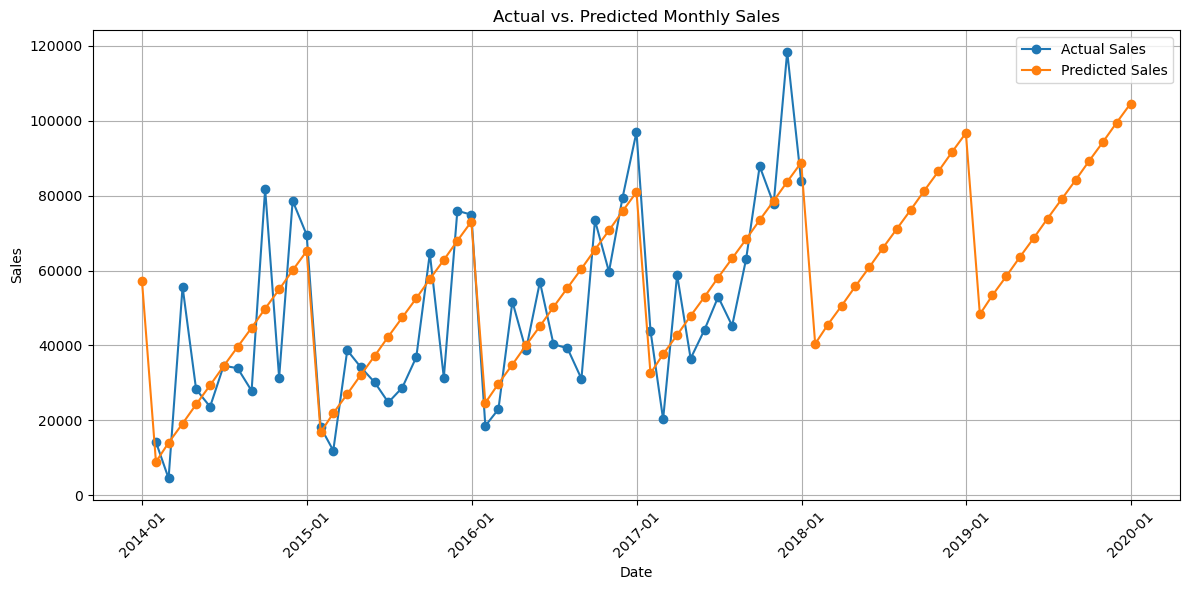

In [212]:
# Convert the 'Date' column to datetime
future_predictions['Date'] = pd.to_datetime(future_predictions['Date'])

# Create a line plot to visualize both actual and predicted sales
plt.figure(figsize=(12, 6))
plt.plot(actual_sales['Date'], actual_sales['Sales'], label='Actual Sales', marker='o')
plt.plot(future_predictions['Date'], future_predictions['Predicted_Sales'], label='Predicted Sales', marker='o')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Monthly Sales')
plt.grid(True)
plt.legend()

# Format x-axis labels to show only years and months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
